In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import os


In [14]:
path = kagglehub.dataset_download("kartikkkc/fraud-data")
print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/kartikkkc/fraud-data/versions/1


In [33]:
downloaded_path = '/root/.cache/kagglehub/datasets/kartikkkc/fraud-data/versions/1'
session_data = pd.read_csv(f"{downloaded_path}/session_related.csv")
outlier_data = pd.read_csv(f"{downloaded_path}/generic_outliers_data.csv")
delivery_data = pd.read_csv(f"{downloaded_path}/delivery_related.csv")


In [34]:
merged_data = session_data.merge(delivery_data, on='OrderId').merge(outlier_data, on='CustId')


In [35]:
merged_data.ffill(inplace=True)


In [36]:
merged_data['IsValidGeo'] = merged_data['IsValidGeo'].map({'YES': 1, 'NO': 0})
merged_data['Fraud'] = merged_data['Fraud'].map({'normal': 0, 'suspicious': 1})
merged_data.drop(['OrderId', 'CustId', 'IP_start_session', 'IP_end_session', 'EmailId', 'MacAddress', 'City'], axis=1, inplace=True)


In [37]:
X = merged_data.drop('Fraud', axis=1)
y = merged_data['Fraud']


In [38]:
X = X[~y.isna()]
y = y.dropna()


In [39]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()


In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [43]:
# Preprocess the training data to convert categorical data to numeric
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [44]:
# Apply SMOTE to the transformed numeric training data
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train_transformed, y_train)


In [45]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])


In [46]:
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Session_Pincode',
                                                   'Delivery_Pincode',
                                                   'IsValidGeo', 'ProductId',
                                                   'OriginalPrice', 'PaidPrice',
                                                   'Age', 'MobileNo',
                                                   'AvgPurchase', 'Pincode']),
                                                 ('cat', OneHotEncoder(),
                                                  ['IsValidAddress',
                                                   'IsAddchangeRecently',
                                                   'IsAddchangeonDel',
                                                   'IsDeliveryRejected',
                                                   'OrderDate',
                                                   'AddressChangeDate',
                                                   'DeliveryDate',
                                                   'ReplacementDate',
                                                   'IsProductConsumable',
                                                   'IsOneTimeUseProduct',
                                                   'IsOfferCodeApplied',
                                                   'OccupationalLevel',
                                                   'IncomeLevel'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [47]:
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7352280701754386
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      1.00      0.85     20954
         1.0       0.00      0.00      0.00      7546

    accuracy                           0.74     28500
   macro avg       0.37      0.50      0.42     28500
weighted avg       0.54      0.74      0.62     28500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

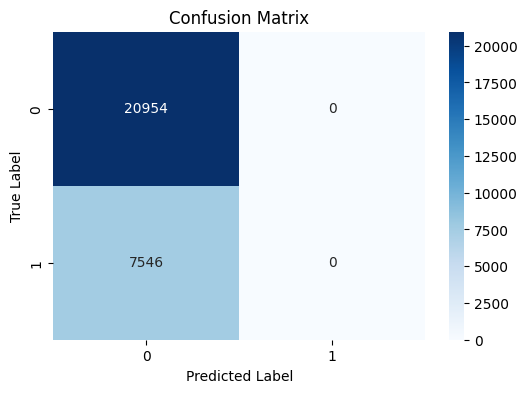

In [48]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
